# *Auxiliar 3:* Seq2seq y Attention

## 📚 Objetivos de la clase 📚

La clase auxiliar de esta semana tendrá los siguientes objetivos:

- Revisar el funcionamiento de las Redes Neuronales Recurrentes (RNNs) y su papel en el procesamiento de secuencias.

- Entender la arquitectura Seq2Seq y cómo se aplica a tareas como la traducción automática, generación de texto y modelado de lenguaje.

- Analizar los desafíos de los modelos Seq2Seq tradicionales, especialmente en secuencias largas, como la pérdida de información contextual.

- Introducir el mecanismo de attention como una solución para superar las limitaciones de los modelos Seq2Seq basados únicamente en RNNs.

- Comparar y contrastar dos enfoques principales de atención:

  - Encoder-Decoder Attention: cómo el decodificador accede dinámicamente a las salidas del codificador.

  - Decoder-Only Attention: cómo modelos como GPT procesan y generan texto sin codificador explícito.

- Observar implementaciones prácticas de estos modelos y analizar su comportamiento en tareas reales.

- Sentar las bases conceptuales para avanzar hacia arquitecturas más complejas como los Transformers.

## 🔬 Experimento 1: NER con BiLSTM

### 🎯 Objetivo

- Entrenar un modelo BiLSTM sobre el dataset CoNLL2003.

- Utilizar GloVe como embeddings preentrenados.

- Evaluar el desempeño sobre el set de validación.

- En una segunda etapa, agregaremos atención.

### 🔹 Dataset
Usaremos el dataset `conll2003` desde Hugging Face.

In [ ]:
!pip install --upgrade datasets

In [ ]:
from datasets import load_dataset
dataset = load_dataset("conll2003")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [ ]:
dataset["train"][0]

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

### 📖 Paso 2: Preparar vocabulario y etiquetas

In [ ]:
from collections import Counter
from itertools import chain

# Construir vocabulario
tokens = list(chain.from_iterable(example['tokens'] for example in dataset['train']))
vocab = ['<PAD>', '<UNK>'] + list(set(tokens))
word2idx = {word: idx for idx, word in enumerate(vocab)}

# Etiquetas
label_list = dataset["train"].features["ner_tags"].feature.names
label2idx = {label: i for i, label in enumerate(label_list)}
idx2label = {i: label for label, i in label2idx.items()}


### 🔹 Embeddings

Descargamos GloVe (p. ej. glove.6B.100d.txt) y cargamos embeddings como matriz para la capa de embedding de PyTorch.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-05-14 20:23:41--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-14 20:23:42--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-14 20:23:42--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
import numpy as np
import torch

def load_glove_embeddings(path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vec = np.array(parts[1:], dtype=np.float32)
            if word in word2idx:
                embeddings[word2idx[word]] = vec
    return torch.tensor(embeddings, dtype=torch.float)

# Ruta a glove.6B.100d.txt
glove_path = "glove.6B.100d.txt"
embedding_matrix = load_glove_embeddings(glove_path, word2idx, embedding_dim=100)

### 🧼 Paso 4: Preprocesamiento

In [ ]:
def encode(example):
    input_ids = [word2idx.get(token, word2idx['<UNK>']) for token in example['tokens']]
    label_ids = example['ner_tags']
    return {'input_ids': input_ids, 'labels': label_ids}

dataset = dataset.map(encode)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

### 🧰 Paso 5: Dataset y DataLoader

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    max_len = max(len(x['input_ids']) for x in batch)
    input_ids = []
    labels = []
    for x in batch:
        ids = x['input_ids']
        lbls = x['labels']
        padding_len = max_len - len(ids)
        input_ids.append(ids + [0] * padding_len)
        labels.append(lbls + [-100] * padding_len)  # Ignora en loss
    return {
        'input_ids': torch.tensor(input_ids, dtype=torch.long),
        'labels': torch.tensor(labels, dtype=torch.long)
    }

BATCH_SIZE = 32
IS_SHUFFLE = True

train_loader = DataLoader(dataset['train'], batch_size=BATCH_SIZE, shuffle=IS_SHUFFLE, collate_fn=collate_fn)
val_loader = DataLoader(dataset['validation'], batch_size=BATCH_SIZE, collate_fn=collate_fn)

### 🔹 Modelo base: BiLSTM para NER

In [ ]:
import torch.nn as nn

class BiLSTM_NER(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_labels):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.lstm = nn.LSTM(input_size=embedding_matrix.size(1), hidden_size=hidden_dim, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(hidden_dim * 2, num_labels)

    def forward(self, input_ids):
        x = self.embedding(input_ids)
        x, _ = self.lstm(x)
        logits = self.classifier(x)
        return logits

### 🏋️ Paso 7: Entrenamiento

In [ ]:
import torch.optim as optim
from tqdm import tqdm

HIDDEN_DIM = 64

model = BiLSTM_NER(embedding_matrix, hidden_dim=HIDDEN_DIM, num_labels=len(label_list))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BiLSTM_NER(
  (embedding): Embedding(23625, 100)
  (lstm): LSTM(100, 64, batch_first=True, bidirectional=True)
  (classifier): Linear(in_features=128, out_features=9, bias=True)
)

In [ ]:
input_ids = next(iter(train_loader))['input_ids'].to(device)
input_ids

tensor([[ 6985, 17640,  8661,  ...,     0,     0,     0],
        [ 9181,   336, 14415,  ...,     0,     0,     0],
        [ 2974,  3541, 14977,  ...,     0,     0,     0],
        ...,
        [ 8596, 12828, 14759,  ...,     0,     0,     0],
        [ 8614,  5734, 14977,  ...,     0,     0,     0],
        [14217,  1504, 16470,  ...,     0,     0,     0]])

In [ ]:
model(input_ids)

tensor([[[ 0.0271, -0.0435, -0.0483,  ..., -0.0533,  0.0387,  0.0177],
         [ 0.0079, -0.0227, -0.0189,  ...,  0.0019, -0.0029,  0.0344],
         [-0.0503, -0.0729, -0.0992,  ..., -0.0184,  0.0622, -0.0201],
         ...,
         [-0.0799, -0.0123, -0.0264,  ..., -0.0948,  0.0622,  0.0931],
         [-0.0756, -0.0118, -0.0223,  ..., -0.0899,  0.0657,  0.0927],
         [-0.0642, -0.0056, -0.0165,  ..., -0.0796,  0.0747,  0.0913]],

        [[-0.0282, -0.0259, -0.0198,  ..., -0.0746, -0.0021,  0.0645],
         [-0.0674, -0.0083, -0.0225,  ..., -0.0277,  0.0077,  0.0213],
         [-0.0897, -0.0168, -0.0520,  ..., -0.0212, -0.0046,  0.0166],
         ...,
         [-0.0799, -0.0124, -0.0264,  ..., -0.0948,  0.0622,  0.0931],
         [-0.0756, -0.0118, -0.0223,  ..., -0.0899,  0.0658,  0.0927],
         [-0.0642, -0.0056, -0.0165,  ..., -0.0796,  0.0747,  0.0913]],

        [[-0.0085,  0.0047, -0.0344,  ...,  0.0276,  0.0292,  0.0037],
         [ 0.0021, -0.0156, -0.0715,  ...,  0

In [ ]:
NUM_EPOCHS = 10
LR = 1e-4

optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss(ignore_index=-100)

train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    # Training
    model.train()
    total_train_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids)
        loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids)
            loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))
            total_val_loss += loss.item()

    # Save losses
    train_losses.append(total_train_loss)
    val_losses.append(total_val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {total_train_loss:.4f} | Val Loss: {total_val_loss:.4f}")


100%|██████████| 439/439 [00:22<00:00, 19.18it/s]


Epoch 1 | Train Loss: 372.3552 | Val Loss: 60.6065


100%|██████████| 439/439 [00:23<00:00, 18.37it/s]


Epoch 2 | Train Loss: 181.2555 | Val Loss: 44.1999


100%|██████████| 439/439 [00:23<00:00, 18.96it/s]


Epoch 3 | Train Loss: 118.0112 | Val Loss: 31.3261


100%|██████████| 439/439 [00:20<00:00, 21.56it/s]


Epoch 4 | Train Loss: 69.3376 | Val Loss: 23.2707


100%|██████████| 439/439 [00:21<00:00, 20.31it/s]


Epoch 5 | Train Loss: 42.4720 | Val Loss: 19.4611


100%|██████████| 439/439 [00:20<00:00, 21.43it/s]


Epoch 6 | Train Loss: 28.2735 | Val Loss: 17.5720


100%|██████████| 439/439 [00:23<00:00, 18.97it/s]


Epoch 7 | Train Loss: 19.7473 | Val Loss: 16.8014


100%|██████████| 439/439 [00:20<00:00, 21.25it/s]


Epoch 8 | Train Loss: 14.2459 | Val Loss: 15.8865


100%|██████████| 439/439 [00:21<00:00, 20.77it/s]


Epoch 9 | Train Loss: 10.3736 | Val Loss: 15.8533


100%|██████████| 439/439 [00:21<00:00, 20.30it/s]


Epoch 10 | Train Loss: 7.7931 | Val Loss: 15.9766


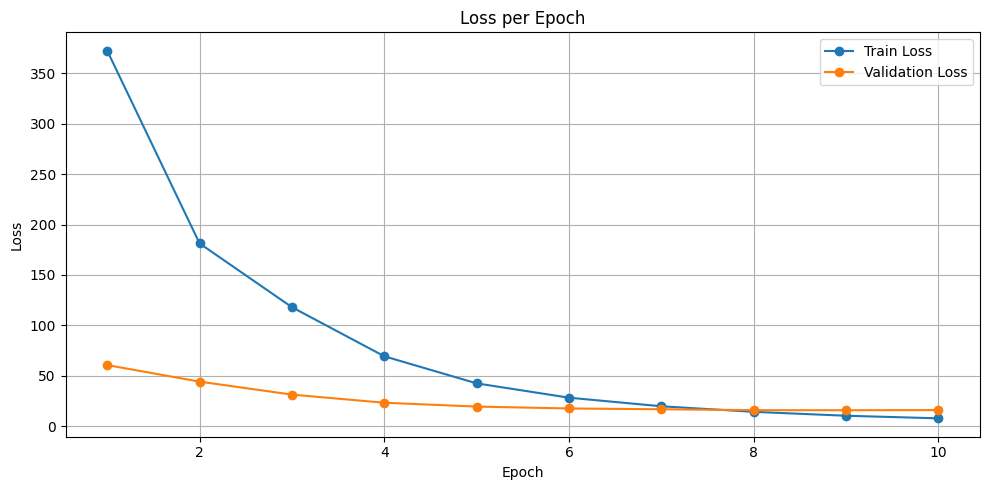

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### ✅ Paso Final: Evaluación sobre el conjunto de prueba

In [ ]:
test_loader = DataLoader(dataset['test'], batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [ ]:
model.eval()
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids)
        predictions = torch.argmax(logits, dim=-1)

        for pred, true in zip(predictions, labels):
            for p, t in zip(pred, true):
                if t != -100:
                    all_test_preds.append(p.item())
                    all_test_labels.append(t.item())

# Reporte final
from sklearn.metrics import classification_report

print("🧪 Desempeño en el conjunto de prueba:")
print(classification_report(all_test_labels, all_test_preds, target_names=label_list))

🧪 Desempeño en el conjunto de prueba:
              precision    recall  f1-score   support

           O       0.95      0.99      0.97     38323
       B-PER       0.93      0.55      0.69      1617
       I-PER       0.94      0.51      0.66      1156
       B-ORG       0.79      0.71      0.75      1661
       I-ORG       0.77      0.67      0.72       835
       B-LOC       0.88      0.83      0.85      1668
       I-LOC       0.67      0.67      0.67       257
      B-MISC       0.81      0.73      0.76       702
      I-MISC       0.61      0.62      0.62       216

    accuracy                           0.93     46435
   macro avg       0.82      0.70      0.74     46435
weighted avg       0.93      0.93      0.93     46435



### 🔬 Ejemplo

In [ ]:
idx2word = {idx: word for idx, word in enumerate(vocab)}

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn.utils.rnn import pad_sequence
from IPython.display import display, HTML

# Example sentence from your test set (tokenized)
example_batch = next(iter(test_loader))
input_ids = example_batch['input_ids'][5].unsqueeze(0).to(device)
true_labels = example_batch['labels'][5]

# Get model prediction
model.eval()
with torch.no_grad():
    logits = model(input_ids)
    predictions = torch.argmax(logits, dim=-1).squeeze(0)

# Convert IDs back to tokens and labels
tokens = [idx2word[int(idx)] for idx in input_ids.squeeze(0).cpu()]
pred_label_names = [label_list[pred.item()] for pred, true in zip(predictions, true_labels) if true != -100]
true_label_names = [label_list[true.item()] for true in true_labels if true != -100]
visible_tokens = [tok for tok, true in zip(tokens, true_labels) if true != -100]

# Visualization: comparison table
def show_prediction_table(tokens, true_labels, pred_labels):
    html = "<table style='border: 1px solid black; border-collapse: collapse;'>"
    html += "<tr><th style='border: 1px solid black;'>Token</th>"
    html += "<th style='border: 1px solid black;'>True Label</th>"
    html += "<th style='border: 1px solid black;'>Predicted Label</th></tr>"

    for token, true, pred in zip(tokens, true_labels, pred_labels):
        color = "lightgreen" if true == pred else "lightcoral"
        html += f"<tr><td style='border: 1px solid black;'>{token}</td>"
        html += f"<td style='border: 1px solid black;'>{true}</td>"
        html += f"<td style='border: 1px solid black; background-color:{color}'>{pred}</td></tr>"
    html += "</table>"
    display(HTML(html))

show_prediction_table(visible_tokens, true_label_names, pred_label_names)

Token,True Label,Predicted Label
China,B-LOC,B-LOC
controlled,O,O
most,O,O
of,O,O
the,O,O
match,O,O
and,O,O
saw,O,O
several,O,O
chances,O,O


## 🧪 Experimento 2: Traducción Automática (Inglés → Español)

### 🎯 Objetivo

- Implementar un sistema de traducción inglés → español.

- Usar un modelo Seq2Seq con RNNs (LSTM):

  - Primero sin atención.

  - Luego agregaremos mecanismo de atención tipo Bahdanau.

- Entrenar sobre el dataset opus_books de Hugging Face.

- Evaluar traducciones sobre el set de validación.

### 📚 Paso 2: Cargar el dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset("opus_books", "en-es")
print(dataset["train"][1])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


{'id': '1', 'translation': {'en': 'Sense and Sensibility', 'es': 'SENTIDO Y SENSIBILIDAD'}}


### ✂️ Preprocesamiento y tokenización

Usaremos torchtext para tokenización simple. También podrías usar sentencepiece si prefieres subpalabras.

In [ ]:
pip install torch

  Using cached torch-2.7.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (29 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.6.77-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.6.77-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.6.80-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.5.1.17-py3-none-manylinux_2_28_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.6.4.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.3.0.4-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.7.77-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.7.1.2-py3-none-manylinux2014_x8

In [ ]:
import re
import torch
from collections import Counter, defaultdict

def tokenize(text):
    return re.findall(r"\b\w+\b", text.lower())

class Vocab:
    def __init__(self, tokens, specials=["<pad>", "<sos>", "<eos>", "<unk>"]):
        self.freqs = Counter(tokens)
        self.itos = list(specials) + [tok for tok in self.freqs if tok not in specials]
        self.stoi = defaultdict(lambda: self.stoi["<unk>"])
        for idx, tok in enumerate(self.itos):
            self.stoi[tok] = idx

    def __getitem__(self, token):
        return self.stoi[token]

    def __len__(self):
        return len(self.itos)

    def get_pad_index(self):
        return self.stoi["<pad>"]

# Fix here: access the proper language inside the translation dict
def yield_tokens(data, lang_code):
    for sample in data:
        yield from tokenize(sample["translation"][lang_code])

train_data = dataset["train"]

tokens_src = list(yield_tokens(train_data, "en"))
tokens_trg = list(yield_tokens(train_data, "es"))

vocab_src = Vocab(tokens_src)
vocab_trg = Vocab(tokens_trg)

### 🔁 Paso 4: Codificar las secuencias

In [ ]:
def encode_pair(example):
    src_tokens = ["<sos>"] + tokenize(example["translation"]["en"]) + ["<eos>"]
    trg_tokens = ["<sos>"] + tokenize(example["translation"]["es"]) + ["<eos>"]
    return {
        "input_ids": torch.tensor([vocab_src[token] for token in src_tokens], dtype=torch.long),
        "target_ids": torch.tensor([vocab_trg[token] for token in trg_tokens], dtype=torch.long)
    }

encoded_dataset = dataset["train"].map(encode_pair).shuffle(seed=42).select(range(1000))

In [ ]:
encoded_dataset

Dataset({
    features: ['id', 'translation', 'input_ids', 'target_ids'],
    num_rows: 1000
})

### 📦 Paso 5: DataLoader

In [ ]:
from datasets import DatasetDict

# First split: train vs temp (val + test)
train_val_test = encoded_dataset.train_test_split(test_size=0.2, seed=42)
train_data = train_val_test["train"]
temp_data = train_val_test["test"]

# Second split: val vs test (from temp)
val_test = temp_data.train_test_split(test_size=0.5, seed=42)
val_data = val_test["train"]
test_data = val_test["test"]

# Combine into a DatasetDict
final_dataset = DatasetDict({
    "train": train_data,
    "validation": val_data,
    "test": test_data
})

In [ ]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    # Convert the "input_ids" and "target_ids" to tensors
    src_batch = [torch.tensor(sample["input_ids"], dtype=torch.long) for sample in batch]
    trg_batch = [torch.tensor(sample["target_ids"], dtype=torch.long) for sample in batch]

    # Pad the sequences
    src_batch = pad_sequence(src_batch, padding_value=vocab_src["<pad>"], batch_first=True)
    trg_batch = pad_sequence(trg_batch, padding_value=vocab_trg["<pad>"], batch_first=True)

    return {"src": src_batch, "trg": trg_batch}

BATCH_SIZE = 8
IS_SHUFFLE = True

train_loader = DataLoader(final_dataset["train"], batch_size=BATCH_SIZE, shuffle=IS_SHUFFLE, collate_fn=collate_fn)
val_loader = DataLoader(final_dataset["validation"], batch_size=BATCH_SIZE, collate_fn=collate_fn)

### 🧠 Paso 6: Modelo Seq2Seq con LSTM (sin atención)

In [ ]:
from torch import nn

class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, (hidden, cell) = self.lstm(embedded)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input, hidden, cell):
        input = input.unsqueeze(1)  # [B] -> [B, 1]
        embedded = self.embedding(input)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(1))  # [B, V]
        return prediction, hidden, cell

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size, trg_len = trg.size()
        vocab_size = self.decoder.fc_out.out_features
        outputs = torch.zeros(batch_size, trg_len, vocab_size).to(src.device)

        hidden, cell = self.encoder(src)
        input = trg[:, 0]  # <sos>

        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:, t] = output
            top1 = output.argmax(1)
            input = trg[:, t] if torch.rand(1).item() < teacher_forcing_ratio else top1

        return outputs

### ⚙️ Entrenamiento

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Seq2Seq(
    Encoder(len(vocab_src), 8, 16),
    Decoder(len(vocab_trg), 8, 16)
)
model.to()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(41627, 8)
    (lstm): LSTM(8, 16, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(67954, 8)
    (lstm): LSTM(8, 16, batch_first=True)
    (fc_out): Linear(in_features=16, out_features=67954, bias=True)
  )
)

In [ ]:
batch = next(iter(train_loader))
src = batch["src"].to(model.encoder.embedding.weight.device)
trg = batch["trg"].to(model.encoder.embedding.weight.device)
model(src, trg)

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0474, -0.3242, -0.0397,  ..., -0.0881,  0.1429, -0.1936],
         [ 0.0738, -0.2416, -0.0431,  ..., -0.1175,  0.1989, -0.1866],
         ...,
         [-0.0094, -0.0568, -0.0233,  ...,  0.2175, -0.0325, -0.0771],
         [-0.0114, -0.0854, -0.0022,  ...,  0.2294, -0.0055, -0.0731],
         [-0.0183, -0.1301,  0.0178,  ...,  0.2384,  0.0095, -0.0653]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0474, -0.3242, -0.0397,  ..., -0.0881,  0.1429, -0.1936],
         [-0.0777, -0.1293, -0.0069,  ...,  0.0249,  0.0411, -0.1269],
         ...,
         [-0.0094, -0.0568, -0.0233,  ...,  0.2175, -0.0325, -0.0771],
         [-0.0114, -0.0854, -0.0022,  ...,  0.2294, -0.0055, -0.0731],
         [-0.0183, -0.1301,  0.0178,  ...,  0.2384,  0.0095, -0.0653]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0734, -0.1913, -0.0681,  ...,  0

In [ ]:
from tqdm import tqdm
LR = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss(ignore_index=vocab_trg["<pad>"])

def train_one_epoch(model, loader):
    model.train()
    epoch_loss = 0
    count_loss = 0
    for batch in tqdm(loader):
        src = batch["src"].to(model.encoder.embedding.weight.device)
        trg = batch["trg"].to(model.encoder.embedding.weight.device)

        output = model(src, trg)
        output = output[:, 1:].reshape(-1, output.shape[-1])
        trg = trg[:, 1:].reshape(-1)

        loss = loss_fn(output, trg)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        count_loss += 1
        print(f"Iteration Loss: {epoch_loss/count_loss:.4f}")
    return epoch_loss / len(loader)

NUM_EPOCHS = 1
for epoch in range(NUM_EPOCHS):
    loss = train_one_epoch(model, train_loader)
    print(f"Epoch {epoch+1}: loss = {loss:.4f}")


  1%|          | 1/100 [00:03<05:06,  3.10s/it]

Iteration Loss: 11.0974


  2%|▏         | 2/100 [00:05<04:01,  2.46s/it]

Iteration Loss: 11.0838


  3%|▎         | 3/100 [00:09<05:08,  3.18s/it]

Iteration Loss: 11.0893


  4%|▍         | 4/100 [00:13<06:06,  3.82s/it]

Iteration Loss: 11.0931


  5%|▌         | 5/100 [00:18<06:16,  3.96s/it]

Iteration Loss: 11.0922


  6%|▌         | 6/100 [00:52<22:18, 14.24s/it]

Iteration Loss: 11.0911


  7%|▋         | 7/100 [00:54<15:43, 10.15s/it]

Iteration Loss: 11.0885


  8%|▊         | 8/100 [00:55<11:31,  7.51s/it]

Iteration Loss: 11.0872


  9%|▉         | 9/100 [00:58<08:56,  5.90s/it]

Iteration Loss: 11.0850


 10%|█         | 10/100 [01:06<09:55,  6.62s/it]

Iteration Loss: 11.0832


 11%|█         | 11/100 [01:10<08:23,  5.65s/it]

Iteration Loss: 11.0827


 12%|█▏        | 12/100 [01:16<08:51,  6.04s/it]

Iteration Loss: 11.0792


 13%|█▎        | 13/100 [01:24<09:22,  6.47s/it]

Iteration Loss: 11.0790


 14%|█▍        | 14/100 [01:36<11:47,  8.23s/it]

Iteration Loss: 11.0765


 15%|█▌        | 15/100 [01:41<10:13,  7.22s/it]

Iteration Loss: 11.0749


 16%|█▌        | 16/100 [01:43<07:41,  5.49s/it]

Iteration Loss: 11.0701


 17%|█▋        | 17/100 [01:47<06:58,  5.04s/it]

Iteration Loss: 11.0701


 18%|█▊        | 18/100 [01:51<06:29,  4.76s/it]

Iteration Loss: 11.0696


 19%|█▉        | 19/100 [01:53<05:22,  3.98s/it]

Iteration Loss: 11.0688


 20%|██        | 20/100 [02:05<08:42,  6.53s/it]

Iteration Loss: 11.0672


 21%|██        | 21/100 [02:08<07:12,  5.47s/it]

Iteration Loss: 11.0658


 22%|██▏       | 22/100 [02:28<12:44,  9.80s/it]

Iteration Loss: 11.0644


 23%|██▎       | 23/100 [02:33<10:31,  8.21s/it]

Iteration Loss: 11.0617


 24%|██▍       | 24/100 [02:35<08:09,  6.45s/it]

Iteration Loss: 11.0609


 25%|██▌       | 25/100 [02:37<06:24,  5.12s/it]

Iteration Loss: 11.0583


 26%|██▌       | 26/100 [02:39<05:12,  4.22s/it]

Iteration Loss: 11.0560


 27%|██▋       | 27/100 [02:40<04:02,  3.32s/it]

Iteration Loss: 11.0525


 28%|██▊       | 28/100 [02:45<04:34,  3.82s/it]

Iteration Loss: 11.0496


 29%|██▉       | 29/100 [02:52<05:27,  4.62s/it]

Iteration Loss: 11.0466


 30%|███       | 30/100 [02:55<04:45,  4.08s/it]

Iteration Loss: 11.0447


 31%|███       | 31/100 [03:05<07:01,  6.12s/it]

Iteration Loss: 11.0426


 32%|███▏      | 32/100 [03:07<05:24,  4.78s/it]

Iteration Loss: 11.0383


 33%|███▎      | 33/100 [03:09<04:30,  4.04s/it]

Iteration Loss: 11.0362


 34%|███▍      | 34/100 [03:15<04:51,  4.41s/it]

Iteration Loss: 11.0330


 35%|███▌      | 35/100 [03:32<08:49,  8.14s/it]

Iteration Loss: 11.0305


 36%|███▌      | 36/100 [03:39<08:19,  7.80s/it]

Iteration Loss: 11.0264


 37%|███▋      | 37/100 [03:40<06:18,  6.01s/it]

Iteration Loss: 11.0224


 38%|███▊      | 38/100 [03:49<07:00,  6.79s/it]

Iteration Loss: 11.0197


 39%|███▉      | 39/100 [03:57<07:10,  7.06s/it]

Iteration Loss: 11.0173


 40%|████      | 40/100 [04:03<06:54,  6.91s/it]

Iteration Loss: 11.0136


 41%|████      | 41/100 [04:16<08:29,  8.63s/it]

Iteration Loss: 11.0101


 42%|████▏     | 42/100 [04:19<06:41,  6.92s/it]

Iteration Loss: 11.0054


 43%|████▎     | 43/100 [04:20<04:53,  5.16s/it]

Iteration Loss: 11.0014


 44%|████▍     | 44/100 [04:26<05:05,  5.45s/it]

Iteration Loss: 10.9963


 45%|████▌     | 45/100 [04:30<04:26,  4.85s/it]

Iteration Loss: 10.9925


 46%|████▌     | 46/100 [04:35<04:29,  5.00s/it]

Iteration Loss: 10.9870


 47%|████▋     | 47/100 [04:37<03:39,  4.14s/it]

Iteration Loss: 10.9816


 48%|████▊     | 48/100 [04:44<04:15,  4.91s/it]

Iteration Loss: 10.9766


 49%|████▉     | 49/100 [04:47<03:46,  4.44s/it]

Iteration Loss: 10.9709


 50%|█████     | 50/100 [04:51<03:39,  4.39s/it]

Iteration Loss: 10.9646


 51%|█████     | 51/100 [04:56<03:35,  4.40s/it]

Iteration Loss: 10.9584


 52%|█████▏    | 52/100 [05:05<04:44,  5.94s/it]

Iteration Loss: 10.9515


 53%|█████▎    | 53/100 [05:14<05:17,  6.75s/it]

Iteration Loss: 10.9446


 54%|█████▍    | 54/100 [05:30<07:26,  9.70s/it]

Iteration Loss: 10.9374


 55%|█████▌    | 55/100 [05:37<06:40,  8.89s/it]

Iteration Loss: 10.9307


 56%|█████▌    | 56/100 [05:40<05:07,  6.98s/it]

Iteration Loss: 10.9230


 57%|█████▋    | 57/100 [05:44<04:22,  6.10s/it]

Iteration Loss: 10.9142


 58%|█████▊    | 58/100 [05:48<03:44,  5.35s/it]

Iteration Loss: 10.9060


 59%|█████▉    | 59/100 [05:53<03:33,  5.21s/it]

Iteration Loss: 10.8986


 60%|██████    | 60/100 [05:59<03:48,  5.70s/it]

Iteration Loss: 10.8900


 61%|██████    | 61/100 [06:09<04:24,  6.78s/it]

Iteration Loss: 10.8812


 62%|██████▏   | 62/100 [06:19<05:01,  7.92s/it]

Iteration Loss: 10.8719


 63%|██████▎   | 63/100 [06:36<06:25, 10.42s/it]

Iteration Loss: 10.8624


 64%|██████▍   | 64/100 [07:12<10:59, 18.32s/it]

Iteration Loss: 10.8522


 65%|██████▌   | 65/100 [07:23<09:22, 16.07s/it]

Iteration Loss: 10.8433


 66%|██████▌   | 66/100 [07:29<07:20, 12.96s/it]

Iteration Loss: 10.8338


 67%|██████▋   | 67/100 [07:35<06:03, 11.00s/it]

Iteration Loss: 10.8232


 68%|██████▊   | 68/100 [07:48<06:11, 11.60s/it]

Iteration Loss: 10.8130


 69%|██████▉   | 69/100 [07:53<04:52,  9.43s/it]

Iteration Loss: 10.8021


 70%|███████   | 70/100 [07:59<04:11,  8.38s/it]

Iteration Loss: 10.7908


 71%|███████   | 71/100 [08:04<03:34,  7.40s/it]

Iteration Loss: 10.7787


 72%|███████▏  | 72/100 [08:08<02:57,  6.34s/it]

Iteration Loss: 10.7664


 73%|███████▎  | 73/100 [08:18<03:21,  7.45s/it]

Iteration Loss: 10.7548


 74%|███████▍  | 74/100 [08:23<03:00,  6.96s/it]

Iteration Loss: 10.7434


 75%|███████▌  | 75/100 [08:26<02:19,  5.59s/it]

Iteration Loss: 10.7321


 76%|███████▌  | 76/100 [08:32<02:19,  5.83s/it]

Iteration Loss: 10.7207


 77%|███████▋  | 77/100 [08:42<02:44,  7.15s/it]

Iteration Loss: 10.7088


 78%|███████▊  | 78/100 [08:48<02:30,  6.82s/it]

Iteration Loss: 10.6965


 79%|███████▉  | 79/100 [08:50<01:50,  5.25s/it]

Iteration Loss: 10.6834


 80%|████████  | 80/100 [09:00<02:14,  6.73s/it]

Iteration Loss: 10.6684


 81%|████████  | 81/100 [09:07<02:08,  6.76s/it]

Iteration Loss: 10.6568


 82%|████████▏ | 82/100 [09:14<02:01,  6.74s/it]

Iteration Loss: 10.6436


 83%|████████▎ | 83/100 [09:16<01:32,  5.43s/it]

Iteration Loss: 10.6313


 84%|████████▍ | 84/100 [09:28<01:58,  7.42s/it]

Iteration Loss: 10.6189


 85%|████████▌ | 85/100 [09:32<01:34,  6.27s/it]

Iteration Loss: 10.6052


 86%|████████▌ | 86/100 [09:42<01:42,  7.33s/it]

Iteration Loss: 10.5913


 87%|████████▋ | 87/100 [09:48<01:30,  6.97s/it]

Iteration Loss: 10.5786


 88%|████████▊ | 88/100 [10:03<01:51,  9.33s/it]

Iteration Loss: 10.5658


 89%|████████▉ | 89/100 [10:10<01:35,  8.69s/it]

Iteration Loss: 10.5527


 90%|█████████ | 90/100 [10:18<01:26,  8.63s/it]

Iteration Loss: 10.5393


 91%|█████████ | 91/100 [10:24<01:10,  7.88s/it]

Iteration Loss: 10.5257


 92%|█████████▏| 92/100 [10:32<01:03,  7.89s/it]

Iteration Loss: 10.5133


 93%|█████████▎| 93/100 [10:36<00:46,  6.67s/it]

Iteration Loss: 10.4997


 94%|█████████▍| 94/100 [10:43<00:41,  6.86s/it]

Iteration Loss: 10.4884


 95%|█████████▌| 95/100 [10:47<00:29,  5.97s/it]

Iteration Loss: 10.4747


 96%|█████████▌| 96/100 [10:56<00:26,  6.75s/it]

Iteration Loss: 10.4623


 97%|█████████▋| 97/100 [11:00<00:18,  6.06s/it]

Iteration Loss: 10.4484


 98%|█████████▊| 98/100 [11:02<00:09,  4.83s/it]

Iteration Loss: 10.4367


 99%|█████████▉| 99/100 [11:12<00:06,  6.30s/it]

Iteration Loss: 10.4232


100%|██████████| 100/100 [11:17<00:00,  6.77s/it]

Iteration Loss: 10.4084
Epoch 1: loss = 10.4084


### Bonus (Visualizar un ejemplo)

```python
def translate_sentence(model, src_tensor, max_len=50):
    model.eval()
    src_tensor = src_tensor.unsqueeze(0).to(model.encoder.embedding.weight.device)
    hidden, cell = model.encoder(src_tensor)

    input = torch.tensor([vocab_trg["<sos>"]], device=src_tensor.device)
    outputs = []

    for _ in range(max_len):
        output, hidden, cell = model.decoder(input, hidden, cell)
        top1 = output.argmax(1).item()
        if top1 == vocab_trg["<eos>"]:
            break
        outputs.append(top1)
        input = torch.tensor([top1], device=src_tensor.device)

    return [vocab_trg.get_itos()[i] for i in outputs]
```

## 🧪 Experimento 3: Generación de Lenguaje – Resumen Automático
> Usaremos un modelo de decoder-only con atención (como GPT), y lo entrenaremos para generar resúmenes de textos.

### 🎯 Objetivo

* Usar el modelo GPT-2 small preentrenado de Hugging Face.

* Fine-tunearlo para que genere resúmenes de noticias del dataset CNN/DailyMail.

* Usar un setup de entrenamiento simple con la librería transformers.

### ⚙️ Estrategia

En lugar de construir el modelo desde cero, para este experimento usaremos Hugging Face Transformers con AutoModelForCausalLM (ej: GPT2) para hacer fine-tuning en tareas de resumen como modelado causal de texto.

In [ ]:
!pip install transformers datasets accelerate evaluate rouge-score

### 📚 Paso 2: Cargar el dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", "3.0.0")
print(dataset["train"][0])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


{'article': 'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office char

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

### 2. Cargar tokenizer y modelo GPT-2

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# GPT2 no tiene token pad token, asignamos para evitar warnings
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

### 3. Tokenización y formato de datos

In [ ]:
max_input_length = 128
max_target_length = 128
prefix = "Article: "
suffix = " Highlights: "

def preprocess_function_autoregressive(examples):
    texts = []
    labels = []

    article, summary = examples["article"][:max_input_length], examples["highlights"][:max_target_length]
    full_text = prefix + article + suffix + summary
    tokenized = tokenizer(
        full_text,
        truncation=True,
    )

    input_ids = tokenized["input_ids"]
    attention_mask = tokenized["attention_mask"]

    # Crear etiquetas enmascaradas: solo calcular pérdida para los tokens del resumen
    label_ids = [-100] * len(input_ids)  # ignorar todo por defecto

    # Encontrar el índice donde empieza el resumen
    highlight_start = tokenizer(prefix + article + suffix, truncation=True)["input_ids"]
    start_index = len(highlight_start)-1

    if start_index < len(label_ids):
        label_ids[start_index-1:-1] = input_ids[start_index:]

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": label_ids,
    }

# Aplicamos a una muestra del dataset
sample_dataset = dataset["train"].shuffle(seed=42).select(range(50))
tokenized_dataset = sample_dataset.map(preprocess_function_autoregressive)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
example = tokenized_dataset[0]
[f"{(i, o)} -> {tokenizer.decode(i), tokenizer.decode(o)}" for i, o in zip(example["input_ids"], example["labels"]) if o != -100]

["(25, 1757) -> (':', ' John')",
 "(1757, 290) -> (' John', ' and')",
 "(290, 764) -> (' and', ' .')",
 "(764, 198) -> (' .', '\\n')",
 "(198, 16353) -> ('\\n', 'Aud')",
 "(16353, 4364) -> ('Aud', 'rey')",
 "(4364, 8261) -> ('rey', ' Cook')",
 "(8261, 547) -> (' Cook', ' were')",
 "(547, 5071) -> (' were', ' discovered')",
 "(5071, 7848) -> (' discovered', ' alongside')",
 "(7848, 511) -> (' alongside', ' their')",
 "(511, 4957) -> (' their', ' daughter')",
 "(4957, 11) -> (' daughter', ',')",
 "(11, 6669) -> (',', ' Ma')",
 "(6669, 49851) -> (' Ma', 'ureen')",
 "(49851, 764) -> ('ureen', ' .')",
 "(764, 198) -> (' .', '\\n')",
 "(198, 2990) -> ('\\n', 'They')",
 "(2990, 547) -> ('They', ' were')",
 "(547, 1043) -> (' were', ' found')",
 "(1043, 379) -> (' found', ' at')",
 "(379, 46656) -> (' at', ' Trem')",
 "(46656, 283) -> (' Trem', 'ar')",
 "(283, 293) -> ('ar', 'le')",
 "(293, 5995) -> ('le', ' Home')",
 "(5995, 3250) -> (' Home', ' Park')",
 "(3250, 287) -> (' Park', ' in')",
 "

### 4. Preparar DataLoaders

In [ ]:
from torch.utils.data import DataLoader
import torch

def collate_fn(batch):
    input_ids = torch.tensor([item["input_ids"] for item in batch], dtype=torch.long)
    labels = torch.tensor([item["labels"] for item in batch], dtype=torch.long)
    attention_mask = (input_ids != tokenizer.pad_token_id).long()
    return {"input_ids": input_ids, "labels": labels, "attention_mask": attention_mask}

# First split: train vs temp (val + test)
train_val = tokenized_dataset.train_test_split(test_size=0.2, seed=42)
train_data = train_val["train"]
val_data = train_val["test"]

train_loader = DataLoader(train_data, batch_size=1, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=1, collate_fn=collate_fn)

### Paso 5: Setup de optimizer y scheduler

In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 3
total_steps = len(train_loader) * num_epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.train()

for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        print(f"Epoch {epoch+1} Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} average loss: {avg_loss:.4f}")

Epoch 1 Loss: 7.8921
Epoch 1 Loss: 7.5280
Epoch 1 Loss: 7.5748
Epoch 1 Loss: 6.6992
Epoch 1 Loss: 7.3486
Epoch 1 Loss: 7.3351
Epoch 1 Loss: 6.7458
Epoch 1 Loss: 7.2154
Epoch 1 Loss: 6.4476
Epoch 1 Loss: 6.8338
Epoch 1 Loss: 6.1181
Epoch 1 Loss: 7.7968
Epoch 1 Loss: 7.4292
Epoch 1 Loss: 7.9053
Epoch 1 Loss: 6.7617
Epoch 1 Loss: 7.3406
Epoch 1 Loss: 7.9235
Epoch 1 Loss: 7.8851
Epoch 1 Loss: 7.8339
Epoch 1 Loss: 6.2315
Epoch 1 Loss: 7.2006
Epoch 1 Loss: 6.3409
Epoch 1 Loss: 6.3901
Epoch 1 Loss: 5.8466
Epoch 1 Loss: 7.5847
Epoch 1 Loss: 5.9704
Epoch 1 Loss: 6.3136
Epoch 1 Loss: 6.6278
Epoch 1 Loss: 7.3663


KeyboardInterrupt: 